# load data

In [5]:
from rfgap import RFGAP
from rfgap_new_issue_experiment import RFGAP_Optimized
# from rfgap_new_issue_diag_and_normalization import RFGAP_Optimized
from sklearn.model_selection import train_test_split
from dataset import dataprep
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from memory_profiler import memory_usage
from sklearn.datasets import fetch_openml


def benchmark_full(name, model_class, kwargs, x_train, y_train, x_test):
    print(f"\n=== Benchmarking {name} ===")

    results = {"Method": name}

    # 1) ---------------- FIT ------------------
    print("\n[1] FIT()")
    model = model_class(**kwargs)

    def run_fit():
        start = time()
        model.fit(x_train, y_train)
        end = time()
        return end - start

    mem_fit = memory_usage(run_fit, interval=0.1, retval=True)
    mem_trace, duration_fit = mem_fit
    peak_fit = max(mem_trace) - min(mem_trace)

    print(f"  Time: {duration_fit:.4f} s")
    print(f"  Peak Memory Increase: {peak_fit:.2f} MiB")

    results["Time_fit"] = duration_fit
    results["Peak_fit"] = peak_fit

    # 2) ------------- GET_PROX ----------------
    print("\n[2] get_proximities()  (train–train)")

    def run_getprox():
        start = time()
        p = model.get_proximities()   # sparse
        end = time()
        return end - start, p

    mem_gp = memory_usage(run_getprox, interval=0.1, retval=True)
    mem_trace_gp, (dur_gp, prox_train) = mem_gp
    peak_gp = max(mem_trace_gp) - min(mem_trace_gp)

    print(f"  Time: {dur_gp:.4f} s")
    print(f"  Peak Memory Increase: {peak_gp:.2f} MiB")

    results["Time_getprox"] = dur_gp
    results["Peak_getprox"] = peak_gp
    results["Prox_train"] = prox_train

    # 3) ------------- EXTEND_PROX ------------
    print("\n[3] prox_extend(x_test)  (test–train)")

    def run_extend():
        start = time()
        p_ext = model.prox_extend(x_test)   # sparse
        end = time()
        return end - start, p_ext

    mem_ext = memory_usage(run_extend, interval=0.1, retval=True)
    mem_trace_ext, (dur_ext, prox_test) = mem_ext
    peak_ext = max(mem_trace_ext) - min(mem_trace_ext)

    print(f"  Time: {dur_ext:.4f} s")
    print(f"  Peak Memory Increase: {peak_ext:.2f} MiB")

    results["Time_extend"] = dur_ext
    results["Peak_extend"] = peak_ext
    results["Prox_test"] = prox_test

    print("\n=== Done ===\n")
    return results
# ==========================================
# 🛡️ THE PROTECTIVE BLOCK 🛡️
# ==========================================
    
# --- Configuration ---
seed = 42
prox_method = 'rfgap'

force_symmetric = True
non_zero_diagonal = True
normalize = False

# force_symmetric = False
# non_zero_diagonal = False
# normalize = False

batch_size = 10000
oob_score = True
verbose = True 
n_jobs = -1


In [2]:
# ==========================================
# 🛡️ FLEXIBLE DATA LOADING
# ==========================================
from medmnist.dataset import INFO, PathMNIST, OrganCMNIST, OrganMNISTAxial
import torchvision.transforms as transforms

dataset_mode = "local"      # options: "local" | "pathmnist" | "synthetic"
# dataset_mode = "organmnist"  # <-- uncomment to load MedMNIST PathMNIST
# dataset_mode = "synthetic"


seed = 42

if dataset_mode == "local":
    try:
        print("Loading local dataset...")
        data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/zilionis_cancer/zilionis.csv')
        # data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/sign_mnist_cropped.csv')
        # data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/packer_c-elegans/celegans_dropna.csv')
        x, y = dataprep(data)
        print("Local data loaded:", x.shape)

    except FileNotFoundError:
        print("⚠️ Local file not found, falling back to synthetic…")
        from sklearn.datasets import make_classification
        x, y = make_classification(n_samples=2000, n_features=50, random_state=seed)

elif dataset_mode == "pathmnist":
    print("Loading PathMNIST…")
    DS = PathMNIST

elif dataset_mode == "organmnist":
    print("Loading OrganMNIST-Axial…")
    DS = OrganMNISTAxial

elif dataset_mode == "synthetic":
    print("Generating synthetic dataset…")
    from sklearn.datasets import make_classification
    x, y = make_classification(n_samples=500, n_features=50, random_state=seed)
    print("Synthetic:", x.shape)

else:
    raise ValueError("Unknown dataset_mode")


# Unified loader for pathmnist / organmnist
if dataset_mode in ["pathmnist", "organmnist"]:
    transform = transforms.Compose([transforms.ToTensor()])

    train_ds = DS(split="train", transform=transform, download=True)
    test_ds  = DS(split="test",  transform=transform, download=True)

    # Flatten images
    x_train_raw = train_ds.imgs.reshape(len(train_ds), -1)
    x_test_raw  = test_ds.imgs.reshape(len(test_ds), -1)

    # Labels
    y_train_raw = train_ds.labels.squeeze()
    y_test_raw  = test_ds.labels.squeeze()

    x = np.vstack([x_train_raw, x_test_raw])
    y = np.concatenate([y_train_raw, y_test_raw])

    print("Loaded:", DS.__name__, x.shape)

# --------------------
# Train/test split
# --------------------
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.01, random_state=seed
)

print(f"Train samples: {x_train.shape[0]}, Features: {x_train.shape[1]}")

Loading local dataset...
Local data loaded: (48969, 306)
Train samples: 48479, Features: 306


In [ ]:

#Old
results_old = benchmark_full(
    name="RFGAP",
    model_class=RFGAP,
    kwargs={
        "prox_method": prox_method,
        "force_symmetric": force_symmetric,
        "non_zero_diagonal": non_zero_diagonal,
        "normalize": normalize,
        "oob_score": oob_score,
        "verbose": verbose,
        'batch_size': batch_size,
        "n_jobs": n_jobs,
        "random_state": seed
    },
    x_train=x_train,
    y_train=y_train,
    x_test=x_test
)

print(results_old['Prox_train'].toarray())
print(results_old['Prox_test'].toarray())

In [6]:

# 2. New (Matrix Multiplication)
results_new = benchmark_full(
    name="RFGAP_Optimized",
    model_class=RFGAP_Optimized,
    kwargs={
        "prox_method": prox_method,
        "force_symmetric": force_symmetric,
        "non_zero_diagonal": non_zero_diagonal,
        "normalize": normalize,
        "oob_score": oob_score,
        "verbose": verbose,
        "n_jobs": n_jobs,
        "random_state": seed
    },
    x_train=x_train,
    y_train=y_train,
    x_test=x_test
)

print(results_new['Prox_train'].toarray())
print(results_new['Prox_test'].toarray())


=== Benchmarking RFGAP_Optimized ===

[1] FIT()


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


  Time: 10.5172 s
  Peak Memory Increase: 651.17 MiB

[2] get_proximities()  (train–train)
  Time: 36.3893 s
  Peak Memory Increase: 10610.73 MiB

[3] prox_extend(x_test)  (test–train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


  Time: 0.2604 s
  Peak Memory Increase: 220.41 MiB

=== Done ===

[[3.30891703e-03 6.00885073e-05 5.27470362e-05 ... 0.00000000e+00
  2.79890329e-04 1.56413677e-04]
 [6.00885073e-05 1.26871533e-02 4.81188874e-05 ... 0.00000000e+00
  1.03739649e-04 1.32196454e-04]
 [5.27470362e-05 4.81188874e-05 8.65733502e-03 ... 0.00000000e+00
  8.44904220e-05 2.45746273e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.04754314e-01
  0.00000000e+00 0.00000000e+00]
 [2.79890329e-04 1.03739649e-04 8.44904220e-05 ... 0.00000000e+00
  5.68076660e-03 7.25011183e-05]
 [1.56413677e-04 1.32196454e-04 2.45746273e-05 ... 0.00000000e+00
  7.25011183e-05 1.91183490e-02]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.44386965e-05
  3.73134320e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.24902261e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.23347826e-04
  0.00000000e+00 0.00000000e+00]
 ...
 [6.44155015e-05 1.73750624e-04

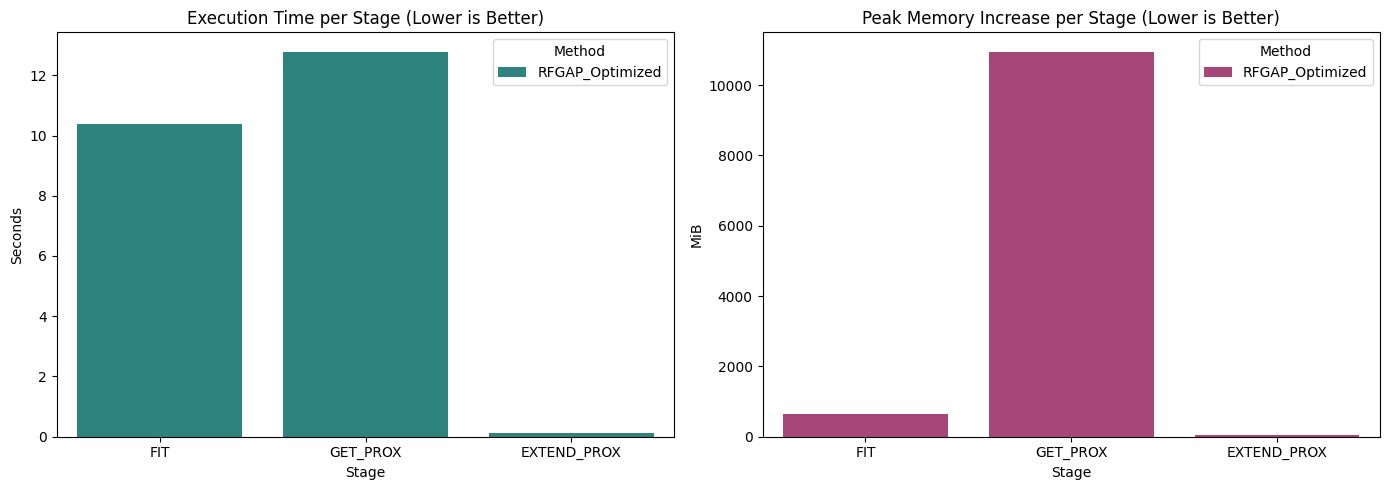

In [4]:
# ---------------------------------------------------------
# Build tidy DataFrame from new benchmark structure
# ---------------------------------------------------------
def to_rows(res):
    """Convert one benchmark result dict into a list of rows."""
    name = res["Method"]
    return [
        {"Method": name, "Stage": "FIT",          "Metric": "Time",  "Value": res["Time_fit"]},
        {"Method": name, "Stage": "GET_PROX",     "Metric": "Time",  "Value": res["Time_getprox"]},
        {"Method": name, "Stage": "EXTEND_PROX",  "Metric": "Time",  "Value": res["Time_extend"]},

        {"Method": name, "Stage": "FIT",          "Metric": "Mem",   "Value": res["Peak_fit"]},
        {"Method": name, "Stage": "GET_PROX",     "Metric": "Mem",   "Value": res["Peak_getprox"]},
        {"Method": name, "Stage": "EXTEND_PROX",  "Metric": "Mem",   "Value": res["Peak_extend"]},
    ]

# Combine old + new results
rows = []
# rows += to_rows(results_old)
rows += to_rows(results_new)

df = pd.DataFrame(rows)

# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- TIME PLOT ---
sns.barplot(
    data=df[df["Metric"]=="Time"],
    x="Stage", y="Value", hue="Method",
    ax=axes[0], palette="viridis"
)
axes[0].set_title("Execution Time per Stage (Lower is Better)")
axes[0].set_ylabel("Seconds")
axes[0].set_xlabel("Stage")
axes[0].legend(title="Method")

# --- MEMORY PLOT ---
sns.barplot(
    data=df[df["Metric"]=="Mem"],
    x="Stage", y="Value", hue="Method",
    ax=axes[1], palette="magma"
)
axes[1].set_title("Peak Memory Increase per Stage (Lower is Better)")
axes[1].set_ylabel("MiB")
axes[1].set_xlabel("Stage")
axes[1].legend(title="Method")

plt.tight_layout()
plt.show()